In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from tensorflow.image import ssim


In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/CS583 Project/'

In [ ]:
img_path = root_path + 'img_data'
image_files = os.listdir(img_path)

In [ ]:
len(image_files)

2460

In [ ]:
images_data = []
for file_name in tqdm(image_files):
  image_path = os.path.join(img_path, file_name)
  image = cv2.imread(image_path)

  #image = cv2.resize(image, (400, 200))
  image = cv2.resize(image, (576, 288))
  #image = cv2.resize(image, (80, 80))


  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresholded_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  #thresholded_image = thresholded_image.astype('float32') / 255.0
  image = np.expand_dims(thresholded_image, axis=-1)
  images_data.append(image)

100%|██████████| 2460/2460 [00:25<00:00, 96.65it/s] 


In [ ]:
images_data = np.array(images_data)

In [ ]:
np.save(root_path+'images_data_400_200.npy', images_data) # save

In [ ]:
images_data = np.load(root_path+'images_data_400_200.npy') #load

In [ ]:
images_data.shape

(2460, 288, 576, 1)

In [ ]:
np.unique(images_data[0])

array([  0, 255], dtype=uint8)

### Model

In [ ]:
input_img = Input(shape=(288, 576, 1))

In [ ]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output has 1 channel for grayscale image


In [ ]:
import tensorflow as tf

# Custom loss function to compare dot positions in columns
def column_dot_position_loss(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, tf.float32)
    y_pred = tf.image.convert_image_dtype(y_pred, tf.float32)

    # Flatten the input images
    y_true_flat = tf.keras.backend.batch_flatten(y_true)
    y_pred_flat = tf.keras.backend.batch_flatten(y_pred)

    # Reshape the flattened images to get column-wise dot positions
    true_cols = tf.reduce_sum(y_true_flat, axis=0)  # Sum along columns
    pred_cols = tf.reduce_sum(y_pred_flat, axis=0)

    # Calculate the absolute difference between dot positions
    dot_position_diff = tf.abs(true_cols - pred_cols)

    # Define a threshold for correct dot position
    threshold = 0  # Adjust as needed

    # Apply heavy penalty for incorrect dot positions
    loss = tf.reduce_sum(tf.nn.relu(dot_position_diff - threshold))

    return loss

# Example usage:
# Assuming y_true and y_pred are the true and predicted images respectively
# (batch_size, height, width, channels)
# Ensure your images are normalized (e.g., range [0, 1])

#loss = column_dot_position_loss(y_true, y_pred)


In [ ]:
autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss=column_dot_position_loss)

In [ ]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 576, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 288, 576, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 144, 288, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 288, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 72, 144, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 144, 128)      73856 

In [ ]:
history = autoencoder.fit(images_data, images_data,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(images_data[:400], images_data[:400]))


Epoch 1/10
77/77 [==============================] - 42s 386ms/step - loss: 218282.1719 - val_loss: 66357.3281
Epoch 2/10
77/77 [==============================] - 22s 286ms/step - loss: 65483.3125 - val_loss: 66357.3281
Epoch 3/10
77/77 [==============================] - 22s 292ms/step - loss: 65479.6406 - val_loss: 66357.3281
Epoch 4/10
77/77 [==============================] - 23s 297ms/step - loss: 65477.8164 - val_loss: 66357.3281
Epoch 5/10
77/77 [==============================] - 23s 299ms/step - loss: 65475.9023 - val_loss: 66357.3281
Epoch 6/10
77/77 [==============================] - 23s 296ms/step - loss: 65477.6016 - val_loss: 66357.3281
Epoch 7/10
77/77 [==============================] - 23s 295ms/step - loss: 65474.2891 - val_loss: 66357.3281
Epoch 8/10
77/77 [==============================] - 23s 298ms/step - loss: 65484.9180 - val_loss: 66357.3281
Epoch 9/10
77/77 [==============================] - 23s 297ms/step - loss: 65484.5000 - val_loss: 66357.3281
Epoch 10/10
77/77 

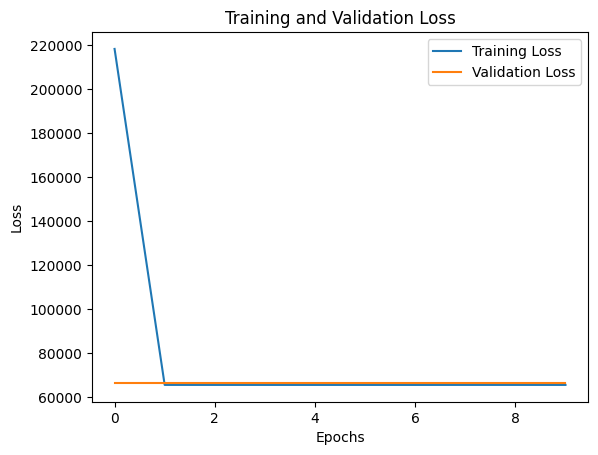

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 520ms/step


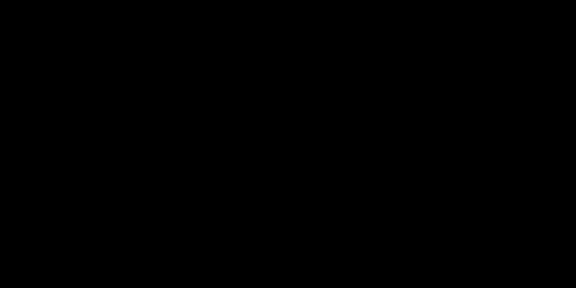

1/1 [==============================] - 0s 33ms/step


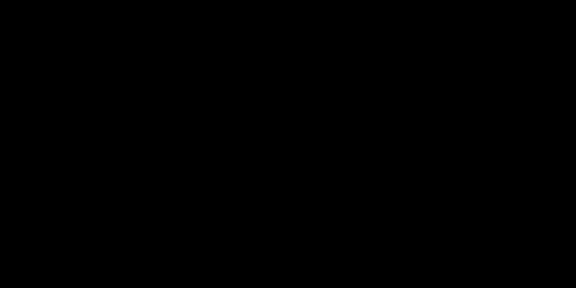

1/1 [==============================] - 0s 29ms/step


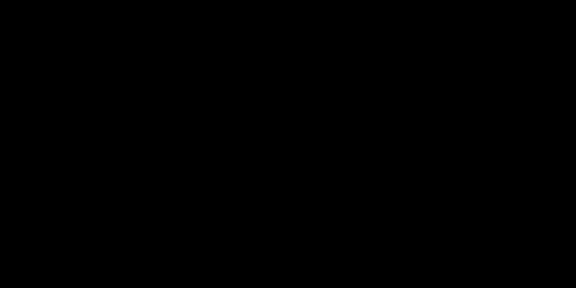

1/1 [==============================] - 0s 26ms/step


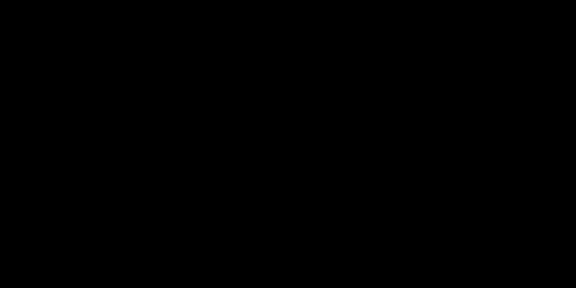

1/1 [==============================] - 0s 25ms/step


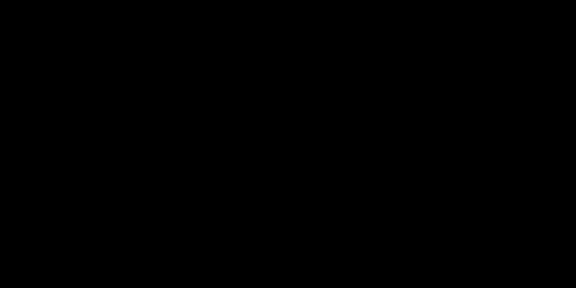

In [ ]:
for i in range(5):
  reconstructed_images = autoencoder.predict(np.expand_dims(images_data[i],0))
  cv2_imshow(reconstructed_images[0])


In [ ]:
i=200
reconstructed_images = autoencoder.predict(np.expand_dims(images_data[i],0))
cv2_imshow(reconstructed_images[0])

### Model 2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Encoder Network
input_img = tf.keras.Input(shape=(200, 400, 1))

# Define encoder layers
x = layers.Conv2D(128, (5, 5), strides=2, padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, (5, 5), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, (5, 5), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Flatten before the fully connected layer
x = layers.Flatten()(x)
encoded = layers.Dense(512, activation='relu')(x)

encoder = Model(input_img, encoded, name='encoder')

# Decoder Network
encoded_input = tf.keras.Input(shape=(512,))
x = layers.Dense(25*50*512, activation='relu')(encoded_input)
x = layers.Reshape((25, 50, 512))(x)

# Define decoder layers
x = layers.Conv2DTranspose(512, (5, 5), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoded = layers.Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, decoded, name='decoder')

# Autoencoder = Encoder + Decoder
encoded_img = encoder(input_img)
decoded_img = decoder(encoded_img)
autoencoder = Model(input_img, decoded_img, name='autoencoder')




In [ ]:
def custom_loss(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, tf.float32)
    y_pred = tf.image.convert_image_dtype(y_pred, tf.float32)

    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))

    alpha = 0.5  # Weight for MSE, you can adjust this balance
    return (alpha * mse) + ((1 - alpha) * ssim_loss)




In [ ]:
import tensorflow as tf

# Custom loss function to compare dot positions in columns
def column_dot_position_loss(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, tf.float32)
    y_pred = tf.image.convert_image_dtype(y_pred, tf.float32)

    # Flatten the input images
    y_true_flat = tf.keras.backend.batch_flatten(y_true)
    y_pred_flat = tf.keras.backend.batch_flatten(y_pred)

    # Reshape the flattened images to get column-wise dot positions
    true_cols = tf.reduce_sum(y_true_flat, axis=0)  # Sum along columns
    pred_cols = tf.reduce_sum(y_pred_flat, axis=0)

    # Calculate the absolute difference between dot positions
    dot_position_diff = tf.abs(true_cols - pred_cols)

    # Define a threshold for correct dot position
    threshold = 0  # Adjust as needed

    # Apply heavy penalty for incorrect dot positions
    loss = tf.reduce_sum(tf.nn.relu(dot_position_diff - threshold))

    return loss

# Example usage:
# Assuming y_true and y_pred are the true and predicted images respectively
# (batch_size, height, width, channels)
# Ensure your images are normalized (e.g., range [0, 1])

#loss = column_dot_position_loss(y_true, y_pred)


In [ ]:
autoencoder.compile(optimizer='adam', loss=column_dot_position_loss)  # Compile the autoencoder with appropriate loss


In [ ]:
# Print the summary of the autoencoder
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 1)]     0         
                                                                 
 encoder (Functional)        (None, 512)               331784192 
                                                                 
 decoder (Functional)        (None, 200, 400, 1)       338977281 
                                                                 
Total params: 670761473 (2.50 GB)
Trainable params: 670757889 (2.50 GB)
Non-trainable params: 3584 (14.00 KB)
_________________________________________________________________


In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
history = autoencoder.fit(images_data, images_data,
                epochs=10,
                batch_size=2,
                shuffle=True,
                validation_data=(images_data[:400], images_data[:400]))


Epoch 1/10


ResourceExhaustedError: ignored

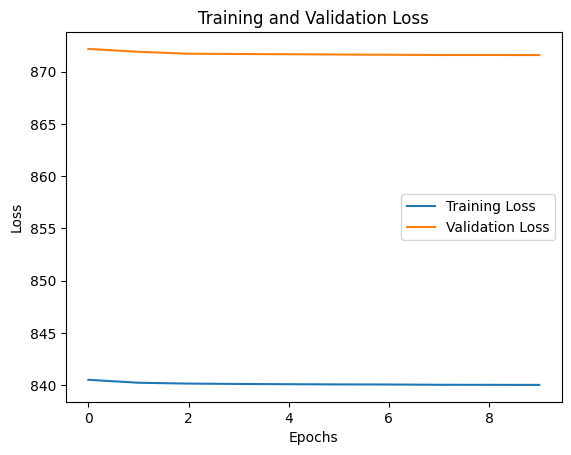

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


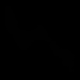

1/1 [==============================] - 0s 19ms/step


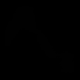

1/1 [==============================] - 0s 19ms/step


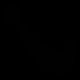

1/1 [==============================] - 0s 19ms/step


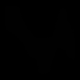

1/1 [==============================] - 0s 22ms/step


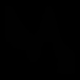

In [ ]:
for i in range(5):
  reconstructed_images = autoencoder.predict(np.expand_dims(images_data[i],0))
  cv2_imshow(reconstructed_images[0])
